# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [975]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
import category_encoders as ce
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")


Итак, прочитаем нашу таблицу:

In [976]:
churn_data = pd.read_csv(r'C:\Users\user\Desktop\Skilfactory\data\churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

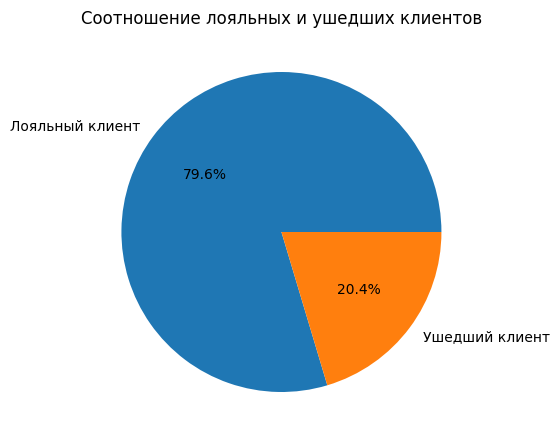

In [977]:
def rename_Exited(number):
  if number == 1:
    return 'Ушедший клиент'
  else:
    return 'Лояльный клиент'

churn_data['Exited_copy'] = churn_data['Exited'].copy()
churn_data['Exited'] = churn_data['Exited'].apply(rename_Exited)
data_Exited = churn_data['Exited'].value_counts()

fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    x=data_Exited,
    labels=data_Exited.index,
    autopct='%.1f%%'
)
axes.set_title('Соотношение лояльных и ушедших клиентов');
plt.show();

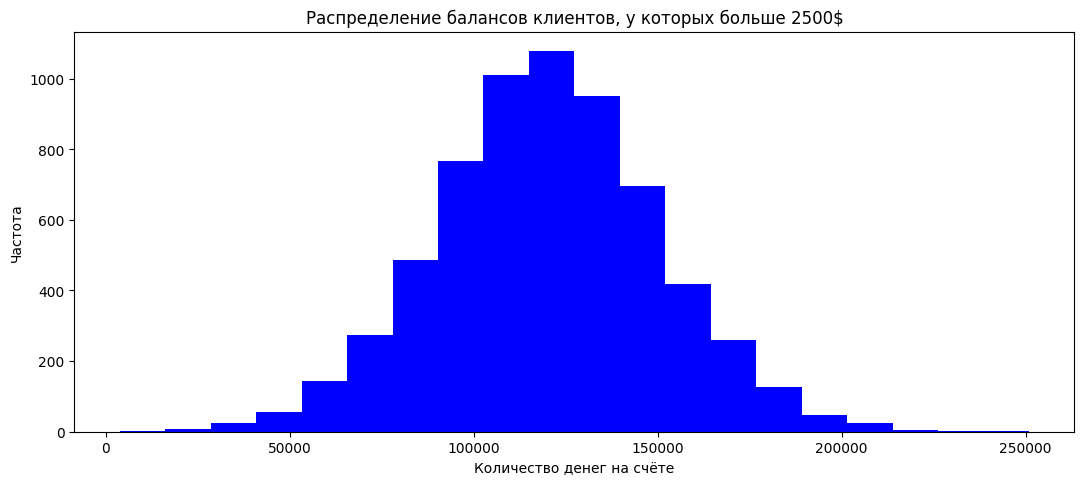

In [978]:
data_balance = churn_data[churn_data['Balance'] > 2500]
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(
    x=data_balance['Balance'],
    bins=20,
    color='blue'

)
axes.set_title('Распределение балансов клиентов, у которых больше 2500$')
axes.set_ylabel('Частота')
axes.set_xlabel('Количество денег на счёте')
plt.show();

C:\Users\user\AppData\Local\Temp\ipykernel_5536\3672374037.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_age = churn_data.groupby(['Group_age', 'Exited'])['Balance'].count().reset_index()


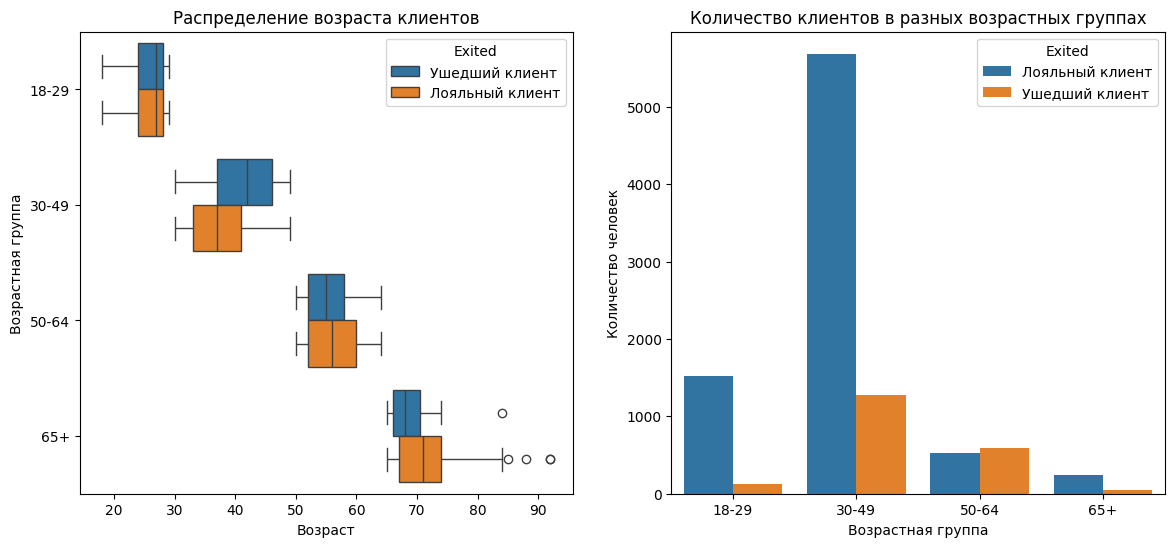

In [979]:
bins = [18, 30, 50, 65, 100]
labels = ['18-29', '30-49', '50-64', '65+']
churn_data['Group_age'] = pd.cut(churn_data['Age'], bins=bins, labels=labels, right=False)

churn_age = churn_data.groupby(['Group_age', 'Exited'])['Balance'].count().reset_index()
churn_age.rename(columns={'Balance': 'Count'}, inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.boxplot(
    data=churn_data,
    x='Age',
    y='Group_age',
    hue='Exited',
    width=0.8,
    dodge=True,
    ax=axes[0]
)
axes[0].set_title('Распределение возраста клиентов')
axes[0].set_ylabel('Возрастная группа')
axes[0].set_xlabel('Возраст');

sns.barplot(
    data=churn_age,
    x='Group_age',
    y='Count',
    hue='Exited',
    ax=axes[1]

)
axes[1].set_title('Количество клиентов в разных возрастных группах')
axes[1].set_ylabel('Количество человек')
axes[1].set_xlabel('Возрастная группа')
plt.show();

C:\Users\user\AppData\Local\Temp\ipykernel_5536\4224690194.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '74.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  churn.loc[0, 'Percent'] = (churn.loc[0, 'Count'] / (churn.loc[0, 'Count'] + churn.loc[1, 'Count'])).round(3) * 100
C:\Users\user\AppData\Local\Temp\ipykernel_5536\4224690194.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(['Мужчины', 'Женщины'])


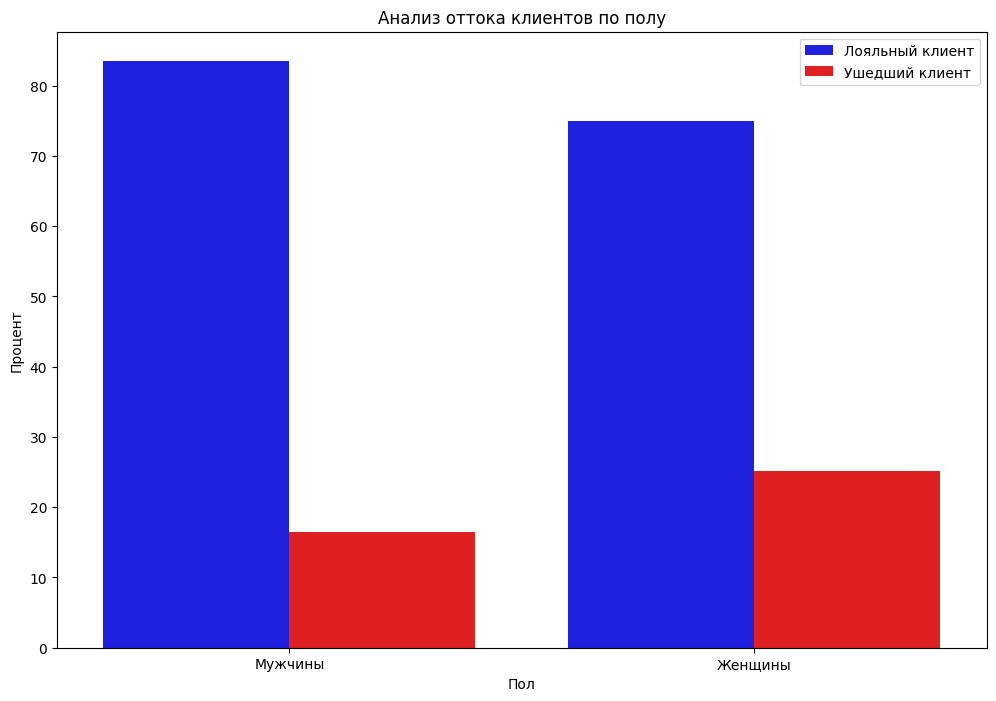

In [980]:
churn = churn_data.groupby(['Gender', 'Exited'])['Balance'].count().reset_index()
churn.rename(columns={'Balance' : 'Count'}, inplace=True)
churn['Percent'] = 0
churn.loc[0, 'Percent'] = (churn.loc[0, 'Count'] / (churn.loc[0, 'Count'] + churn.loc[1, 'Count'])).round(3) * 100
churn.loc[1, 'Percent'] = (churn.loc[1, 'Count'] / (churn.loc[0, 'Count'] + churn.loc[1, 'Count'])).round(3) * 100
churn.loc[2, 'Percent'] = (churn.loc[2, 'Count'] / (churn.loc[2, 'Count'] + churn.loc[3, 'Count'])).round(3) * 100
churn.loc[3, 'Percent'] = (churn.loc[3, 'Count'] / (churn.loc[2, 'Count'] + churn.loc[3, 'Count'])).round(3) * 100

fig = plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=churn,
    x='Gender',
    y='Percent',
    hue='Exited',
    order=['Male', 'Female'],
    hue_order=['Лояльный клиент', 'Ушедший клиент'],
    palette={'Лояльный клиент': 'bLue', 'Ушедший клиент': 'red'}
)

barplot.legend(
    title='Статус',
    labels=['Лояльный клиент', 'Ушедший клиент'],
    loc='upper right'
)
barplot.legend(loc='upper right')
barplot.set_title('Анализ оттока клиентов по полу')
barplot.set_xlabel('Пол')
barplot.set_xticklabels(['Мужчины', 'Женщины'])
barplot.set_ylabel('Процент')
plt.show();


C:\Users\user\AppData\Local\Temp\ipykernel_5536\2943924631.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(['Лояльные клиенты', 'Ушедшие клиенты'])


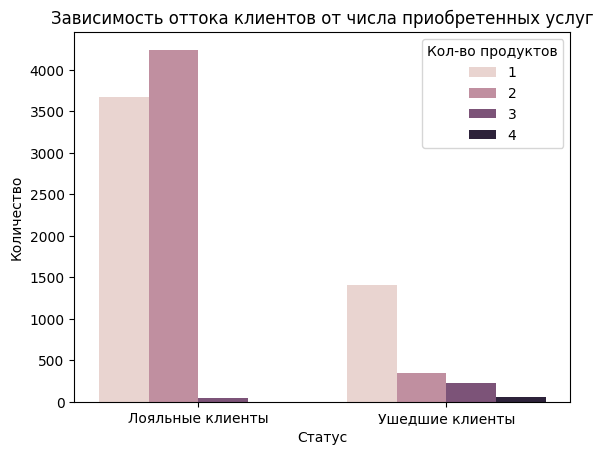

In [981]:
churn_data_products = churn_data.groupby(['NumOfProducts', 'Exited'])['Balance'].count().reset_index()
churn_data_products.rename(columns={'Balance' : 'Count'}, inplace=True)

barplot = sns.barplot(
    data=churn_data_products,
    x='Exited',
    y='Count',
    hue='NumOfProducts'
)
barplot.set_xticklabels(['Лояльные клиенты', 'Ушедшие клиенты'])
barplot.legend(title='Кол-во продуктов')
barplot.set_title('Зависимость оттока клиентов от числа приобретенных услуг')
barplot.set_ylabel('Количество')
barplot.set_xlabel('Статус')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_5536\3042702107.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(['Лояльные клиенты', 'Ушедшие клиенты'])


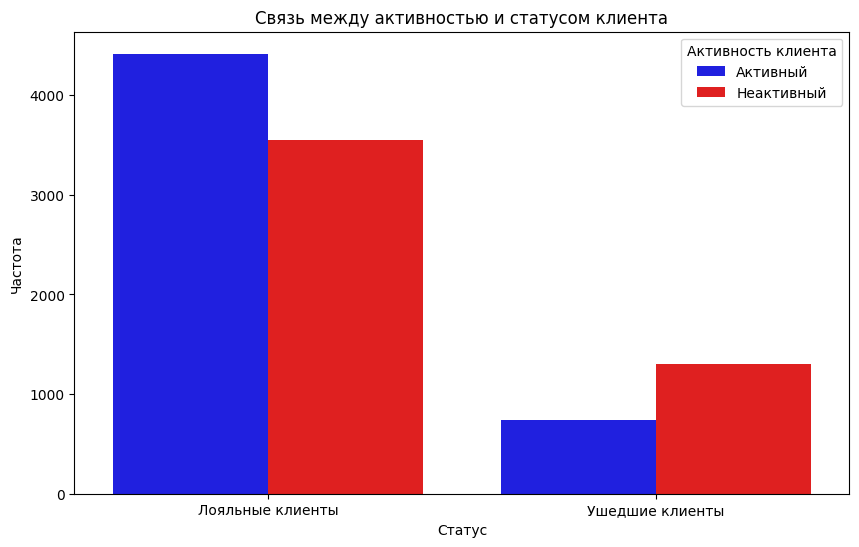

In [982]:
churn_data_active_member = churn_data.groupby(['IsActiveMember', 'Exited'])['Balance'].count().reset_index()
churn_data_active_member.rename(columns={'Balance' : 'Count'}, inplace=True)

fig = plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=churn_data_active_member,
    x='Exited',
    y='Count',
    hue='IsActiveMember',
    hue_order=[1, 0],
    palette={1: 'bLue', 0: 'red'}
)
handles, _ = barplot.get_legend_handles_labels()
barplot.legend(
    handles=handles,
    title='Активность клиента',
    labels=['Активный', 'Неактивный']
    )

barplot.set_xticklabels(['Лояльные клиенты', 'Ушедшие клиенты'])
barplot.set_title('Связь между активностью и статусом клиента')
barplot.set_xlabel('Статус')
barplot.set_ylabel('Частота')
plt.show();

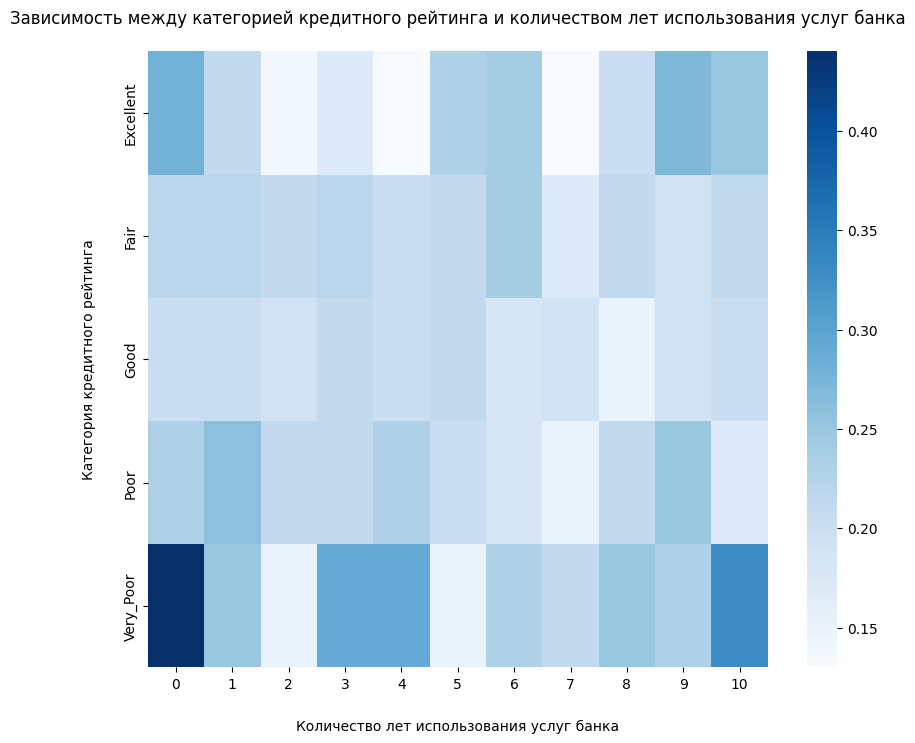

In [983]:
def get_credit_score_cat(credit_score):
    if credit_score >= 300 and credit_score < 500:
        return "Very_Poor"
    elif credit_score >= 500 and credit_score < 601:
        return "Poor"
    elif credit_score >= 601 and credit_score < 661:
        return "Fair"
    elif credit_score >= 661 and credit_score < 781:
        return "Good"
    elif credit_score >= 781 and credit_score < 851:
        return "Excellent"
    elif credit_score >= 851:
        return "Top"
    elif credit_score < 300:
        return "Deep"
    
churn_data['CreditScoreCat'] = churn_data['CreditScore'].apply(get_credit_score_cat)

pivot = churn_data.pivot_table(
    index='CreditScoreCat',
    columns='Tenure',
    values='Exited_copy'
).round(2)

fig = plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(data=pivot, cmap='Blues')
heatmap.set_title('Зависимость между категорией кредитного рейтинга и количеством лет использования услуг банка', pad=20)
heatmap.set_xlabel('Количество лет использования услуг банка', labelpad=20)
heatmap.set_ylabel('Категория кредитного рейтинга', labelpad=20)
plt.show();

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [984]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 17)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [985]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Exited_copy,Group_age,CreditScoreCat
7,376,Female,29,4,115046.74,4,1,0,119346.88,Ушедший клиент,1,18-29,Very_Poor
15,616,Male,45,3,143129.41,2,0,1,64327.26,Лояльный клиент,0,30-49,Fair
16,653,Male,58,1,132602.88,1,1,0,5097.67,Ушедший клиент,1,50-64,Fair
26,756,Male,36,2,136815.64,1,1,1,170041.95,Лояльный клиент,0,30-49,Good
28,574,Female,43,3,141349.43,1,1,1,100187.43,Лояльный клиент,0,30-49,Poor


Проверим, что в наших данных нет пропусков:

In [986]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
Exited_copy        0
Group_age          0
CreditScoreCat     0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [987]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2509 entries, 7 to 9998
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      2509 non-null   int64   
 1   Gender           2509 non-null   object  
 2   Age              2509 non-null   int64   
 3   Tenure           2509 non-null   int64   
 4   Balance          2509 non-null   float64 
 5   NumOfProducts    2509 non-null   int64   
 6   HasCrCard        2509 non-null   int64   
 7   IsActiveMember   2509 non-null   int64   
 8   EstimatedSalary  2509 non-null   float64 
 9   Exited           2509 non-null   object  
 10  Exited_copy      2509 non-null   int64   
 11  Group_age        2509 non-null   category
 12  CreditScoreCat   2509 non-null   object  
dtypes: category(1), float64(2), int64(7), object(3)
memory usage: 257.5+ KB


In [988]:
churn_data[churn_data.duplicated()].sum(numeric_only=True)

CreditScore        0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited_copy        0.0
dtype: float64

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [989]:
churn_data['Exited'] = churn_data['Exited_copy']
churn_data.drop('Exited_copy', axis=1, inplace=True)

In [990]:
# Создаём новые признаки
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']

# Кодируем текстовые признаки
bin_encoder = ce.BinaryEncoder(cols=['Gender', 'Group_age', 'CreditScoreCat'])
churn_data = bin_encoder.fit_transform(churn_data)

# Статистическая информация
# Логарифмируем признак и удалим аномалии, чтобы исправить распределение 
churn_data['BalanceSalaryRatio'] = np.log1p(churn_data['BalanceSalaryRatio'])
churn_data = churn_data[churn_data['BalanceSalaryRatio'] < 4]
churn_data.describe()

,CreditScore,Gender_0,Gender_1,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Group_age_0,Group_age_1,Group_age_2,CreditScoreCat_0,CreditScoreCat_1,CreditScoreCat_2,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
count,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000
mean,651.377724,0.526634,0.473366,39.768362,4.999596,119718.458144,1.520985,0.715496,0.497982,102364.760061,0.323245,0.027845,0.823245,0.280872,0.334140,0.596852,0.529863,0.991780,0.134053,17.532442
std,98.125517,0.499391,0.499391,10.530864,2.933732,27077.743805,0.620732,0.451269,0.500097,57534.991553,0.467810,0.164562,0.381539,0.449516,0.471784,0.490629,0.499208,0.622951,0.087704,5.367558
min,350.000000,0.000000,0.000000,18.000000,0.000000,27288.430000,1.000000,0.000000,0.000000,1787.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.176121,0.000000,6.112676
25%,584.000000,0.000000,0.000000,32.000000,2.000000,102772.802500,1.000000,0.000000,0.000000,52582.417500,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.576647,0.060606,13.685854
50%,651.000000,1.000000,0.000000,38.000000,5.000000,119692.280000,1.000000,1.000000,0.000000,103292.370000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.782024,0.125000,16.859127
75%,722.000000,1.000000,1.000000,45.000000,8.000000,137634.385000,2.000000,1.000000,1.000000,151797.550000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.205360,0.200000,20.859069
max,850.000000,1.000000,1.000000,84.000000,10.000000,214346.960000,4.000000,1.000000,1.000000,199970.740000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.995304,0.500000,46.388889


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [991]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [992]:
y.value_counts(normalize=True)

Exited
0    0.676755
1    0.323245
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [993]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1858, 19)
Test shape: (620, 19)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [994]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.676534
1    0.323466
Name: proportion, dtype: float64



Test :


Exited
0    0.677419
1    0.322581
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [995]:
#  Стандартизируем признаки распределение которых близко к нормальному
r_standart = preprocessing.StandardScaler()
r_standart = r_standart.fit(X_train[['CreditScore', 'Age', 'Balance', 'CreditScoreGivenAge']])
X_train[['CreditScore', 'Age', 'Balance', 'CreditScoreGivenAge']] = r_standart.transform(X_train[['CreditScore', 'Age', 'Balance', 'CreditScoreGivenAge']])
X_test[['CreditScore', 'Age', 'Balance', 'CreditScoreGivenAge']] = r_standart.transform(X_test[['CreditScore', 'Age', 'Balance', 'CreditScoreGivenAge']])

# Признак BalanceSalaryRatio имеет выбросы, нормализируем его с помощью RobustScaler
r_robust = preprocessing.RobustScaler()
r_robust = r_robust.fit(X_train[['BalanceSalaryRatio']])
X_train[['BalanceSalaryRatio']] = r_robust.transform(X_train[['BalanceSalaryRatio']])
X_test[['BalanceSalaryRatio']] = r_robust.transform(X_test[['BalanceSalaryRatio']])

# Бинарные признаки не трогаем, остальные признаки нормализируем с помощью MinMaxScaler
r_minmax = preprocessing.MinMaxScaler()
r_minmax = r_minmax.fit(X_train[['EstimatedSalary', 'Tenure']])
X_train[['EstimatedSalary', 'Tenure']] = r_minmax.transform(X_train[['EstimatedSalary', 'Tenure']])
X_test[['EstimatedSalary', 'Tenure']] = r_minmax.transform(X_test[['EstimatedSalary', 'Tenure']])

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

Нам необходимо выбрать f-меру, так как нам надо минимизировать как ложноположительные, так и ложноотрицательные срабатывания модели.
То есть нам надо иметь хорошие показатели и precision, и recall. Если хотя бы 1 метрика будет равнятся 0, то f-мера также будет 0.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [996]:
# Создаём объект
log_reg = linear_model.LogisticRegression(random_state=42)
# Обучаем на тренировочной выборке
log_reg.fit(X_train, y_train)

# Получаем предсказания
y_train_predict = log_reg.predict(X_train)
y_test_predict = log_reg.predict(X_test)

#Модель log_reg:
print('Результаты модели на тренировочной выборке:')
print('Accuracy : {:.2f}'.format(metrics.accuracy_score(y_train, y_train_predict)))
print('Precision: {:.2f}'.format(metrics.precision_score(y_train, y_train_predict)))
print('Recall: {:.2f}'.format(metrics.recall_score(y_train, y_train_predict)))
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_predict)))

print('\nРезультаты модели на тестовой выборке:')
print('Accuracy : {:.2f}'.format(metrics.accuracy_score(y_test, y_test_predict)))
print('Precision: {:.2f}'.format(metrics.precision_score(y_test, y_test_predict)))
print('Recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_predict)))
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_test_predict)))


Результаты модели на тренировочной выборке:
Accuracy : 0.75
Precision: 0.68
Recall: 0.44
F1 score: 0.53

Результаты модели на тестовой выборке:
Accuracy : 0.75
Precision: 0.67
Recall: 0.45
F1 score: 0.54


Наша модель оптимальна, результаты всех метрик сильно не отличаются, что говорит о том, что модель смогла выявить закономерность, которая описывает данные как на тренировочной, так и на тестовой выборке. Однако наша целевая метрика чуть превышает 0.5, поэтому стоит поэксперементировать и найти более сильную модель.

In [997]:
for i in np.arange(0.25, 2.25, 0.25):
    log_reg = linear_model.LogisticRegression(random_state=42, C=2)
    # Обучаем на тренировочной выборке
    log_reg.fit(X_train, y_train)

    # Получаем предсказания
    y_train_predict = log_reg.predict(X_train)
    y_test_predict = log_reg.predict(X_test)

    #Модель log_reg:
    print(f'Модель при c={i}:')
    print('Результаты модели на тренировочной выборке:')
    print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_predict)))
    print('Результаты модели на тестовой выборке:')
    print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_test_predict)))
    print('')

Модель при c=0.25:
Результаты модели на тренировочной выборке:
F1 score: 0.53
Результаты модели на тестовой выборке:
F1 score: 0.54

Модель при c=0.5:
Результаты модели на тренировочной выборке:
F1 score: 0.53
Результаты модели на тестовой выборке:
F1 score: 0.54

Модель при c=0.75:
Результаты модели на тренировочной выборке:
F1 score: 0.53
Результаты модели на тестовой выборке:
F1 score: 0.54

Модель при c=1.0:
Результаты модели на тренировочной выборке:
F1 score: 0.53
Результаты модели на тестовой выборке:
F1 score: 0.54

Модель при c=1.25:
Результаты модели на тренировочной выборке:
F1 score: 0.53
Результаты модели на тестовой выборке:
F1 score: 0.54

Модель при c=1.5:
Результаты модели на тренировочной выборке:
F1 score: 0.53
Результаты модели на тестовой выборке:
F1 score: 0.54

Модель при c=1.75:
Результаты модели на тренировочной выборке:
F1 score: 0.53
Результаты модели на тестовой выборке:
F1 score: 0.54

Модель при c=2.0:
Результаты модели на тренировочной выборке:
F1 score: 

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [1018]:
# Создаём полиномиальные признаки
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

# Обучаем новую модель
log_reg_poly = linear_model.LogisticRegression(random_state=42)
log_reg_poly.fit(X_train_poly, y_train)

y_train_poly_predict = log_reg_poly.predict(X_train_poly)
y_test_poly_predict = log_reg_poly.predict(X_test_poly)

#Модель log_reg_poly:
print('Результаты модели на тренировочной выборке:')
print('Accuracy : {:.2f}'.format(metrics.accuracy_score(y_train, y_train_poly_predict)))
print('Precision: {:.2f}'.format(metrics.precision_score(y_train, y_train_poly_predict)))
print('Recall: {:.2f}'.format(metrics.recall_score(y_train, y_train_poly_predict)))
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_poly_predict)))

print('\nРезультаты модели на тестовой выборке:')
print('Accuracy : {:.2f}'.format(metrics.accuracy_score(y_test, y_test_poly_predict)))
print('Precision: {:.2f}'.format(metrics.precision_score(y_test, y_test_poly_predict)))
print('Recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_poly_predict)))
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_test_poly_predict)))

Результаты модели на тренировочной выборке:
Accuracy : 0.70
Precision: 0.56
Recall: 0.31
F1 score: 0.40

Результаты модели на тестовой выборке:
Accuracy : 0.72
Precision: 0.61
Recall: 0.36
F1 score: 0.46


Новая модель, построенная на полиномиальных признаках 3 степени, не даёт улучшения целевой метрики F1 score. В обучение участвовало около 1500 параметров, скорее всего для модели эти данные избыточны, поэтому она и неспособна описать зависимость лучшим образом. Чтобы повысить качество модели следует действовать другим путём.

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [1031]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(log_reg.predict_proba(X_test)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = metrics.f1_score(y_test, y_test_predict)
    # Добавляем результат в список
    scores.append(score)
print(scores)

[0.5405405405405406, 0.5405405405405406, 0.5405405405405406, 0.5405405405405406, 0.5405405405405406, 0.5405405405405406, 0.5405405405405406, 0.5405405405405406, 0.5405405405405406, 0.5405405405405406, 0.5405405405405406, 0.5405405405405406, 0.5405405405405406, 0.5405405405405406, 0.5405405405405406, 0.5405405405405406, 0.5405405405405406, 0.5405405405405406]


## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [1000]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1858, 19)
Test shape: (620, 19)


Импортируем необходимые для выполнения практики модули:

In [1001]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [1002]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [1003]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [1004]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

In [1005]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [1006]:
# Ваш код здесь